Once deleted, variables cannot be recovered. Proceed (y/[n])? y
iris.data shape        : (150, 4)
iris.target shape      : (150,)
iris.target_names shape: (3,)
iris.target_names      : ['setosa' 'versicolor' 'virginica']
iris.feature_names     : ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
nb_rows                : 150  nb_cols: 4
nb_training_rows       : 105  nb_test_rows: 45
training_dataset shape : (105, 4)
training_labels shape  : (105,)
testing_dataset shape  : (45, 4)
testing_labels shape   : (45,)
Wrong match for this entry:  [4.9 2.5 4.5 1.7]  Expected label:  2  Actual label:  1
Wrong match for this entry:  [5.7 2.5 5.  2. ]  Expected label:  2  Actual label:  1
Wrong match for this entry:  [6.  2.2 5.  1.5]  Expected label:  2  Actual label:  1
Wrong match for this entry:  [6.3 2.7 4.9 1.8]  Expected label:  2  Actual label:  1
Wrong match for this entry:  [6.2 2.8 4.8 1.8]  Expected label:  2  Actual label:  1
Wrong match for this entry: 

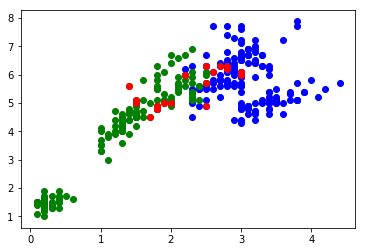

In [92]:
"""
Source: http://scikit-learn.org/stable/modules/naive_bayes.html

Info about the Iris dataset: http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

TODO: 
1) Group the steps into functions. Consider classes.
2) Improve the plotting. Unsure how to plot 4D data.
3) Try with another dataset
4) Ask group for feedback

""" 

%reset

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
import numpy as np

import matplotlib.pyplot as plt


"""
Step 1: Load the dataset

iris.data         : The dataset representing a table of flower measurements. 4 measurements, 150 rows.
iris.feature_names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

iris.target       : Dataset targets (aka labels)
iris.target_names : ['setosa' 'versicolor' 'virginica'] human readable names corresponding to the labels. 

"""
iris = datasets.load_iris()


"""
Step 2: clean/prepare the data

Looks like the data doesn't need cleaning.
However the data need to be separated into a training and testing dataset:
- Extracts a training dataset from the initial dataset. (first 70% of dataset)
- Extracts a testing dataset from the initial dataset. (last 30% of dataset)

"""
nb_rows, nb_cols = np.shape(iris.data)
nb_training_rows = (int)(nb_rows * 0.7)
nb_test_rows = nb_rows - nb_training_rows

training_dataset = iris.data[:nb_training_rows, ]
testing_dataset = iris.data[nb_training_rows:,]

training_labels = iris.target[:nb_training_rows, ]
testing_labels = iris.target[nb_training_rows:, ]

# Code below is just to get familiar with the dataset.
#print(iris)
print("iris.data shape        :", np.shape(iris.data))   # A multi-dimension array
print("iris.target shape      :", np.shape(iris.target)) # Target = labels in CE4031. There are a lot of entries but their range is only:{0,1,2}
print("iris.target_names shape:", np.shape(iris.target_names)) # human readable names corresponding to the above labels.
print("iris.target_names      :", iris.target_names)
print("iris.feature_names     :", iris.feature_names)
#print("iris.DESCR:", iris.DESCR)
print("nb_rows                :", nb_rows, " nb_cols:", nb_cols)
print("nb_training_rows       :", nb_training_rows, " nb_test_rows:", nb_test_rows)
print("training_dataset shape :", np.shape(training_dataset))
print("training_labels shape  :", np.shape(training_labels))
print("testing_dataset shape  :", np.shape(testing_dataset))
print("testing_labels shape   :", np.shape(testing_labels))


"""
Step 3: Train

"""
gnb = GaussianNB()
gnb.fit(training_dataset, training_labels)


"""
Step 4: Test

"""
results = gnb.predict(testing_dataset)
error_features = []
error_labels = []
for i in range(0, nb_test_rows):
    if results[i] != testing_labels[i]:       
        error_features.append(testing_dataset[i,:].tolist())
        error_labels.append(results[i])
        print("Wrong match for this entry: ", testing_dataset[i], 
              " Expected label: ", testing_labels[i],
              " Actual label: ", results[i])

# Convert the list to a np.array so that we can slice it at step 5 for plotting.
np_error_features = np.array(error_features)
        
print("error features   :", error_features)
print("error labels     :", error_labels)
print("np_error_features:", np_error_features)


"""
Step 5: Visualise

Unsure how to visualise the data.

Green dots: Petal length and width
Blue dots : Sepal length and width
Red dots  : Petal and Sepal that were not matched properly by the classifier.

"""
sepal_length = iris.data[:,0]
sepal_width = iris.data[:,1]
petal_length = iris.data[:,2]
petal_width = iris.data[:,3]

plt.scatter(sepal_width, sepal_length, c='b')
plt.scatter(petal_width, petal_length, c='g')

# plot mismatches 
error_sepal_length = np_error_features[:,0]
error_sepal_length = np_error_features[:,0]
error_sepal_width = np_error_features[:,1]
error_petal_length = np_error_features[:,2]
error_petal_width = np_error_features[:,3]

plt.scatter(error_sepal_width, error_sepal_length, c='r')
plt.scatter(error_petal_width, error_petal_length, c='r')

plt.show()

# Observations
Out of 45 test samples, 10 were mis-classified. This gives us a **success rate of 77.77%** and a **fail rate of 22.22%**